# Forecast with Cold Start Items

Consider the situation where a set of related new items are introduced into your catalog.  This could be due to bringing a brand new product to market, offering a product for the first time that was in the market and sold by others or taking a product into a new region.

Despite having no historical data for the new product available, one needs to forecast the future values for those items.


In such a situation, when no demand history is available for items, this scenario is coined as a "cold-start problem".  Amazon Forecast is able to handle this situation easily, when you use the [Auto Predictor](https://github.com/aws-samples/amazon-forecast-samples/blob/main/library/content/AutoPredictor.md).

<img src="../../common/images/amazon_forecast.png">


# Introduction

In this notebook, we walk through the process of generating forecasts for cold start items.  An important note --  generating predictions for cold-start items does require an [Item Metadata](https://github.com/aws-samples/amazon-forecast-samples/blob/main/library/content/ItemMetadata.md) dataset.  The Item Metadata contains categorical data about existing established items as well as your new cold-start items.  Amazon Forecast considers the categorical features of your cold-start items and finds similar items with established historical demand to help estimate demand for the new items.

In this example, we are using a feature called "type" in the item metadata file where there is a near even distribution of items across types A, B, C, and D.  A new cold-start item with type "D" will tend to have it's future demand created by true historical values from other "D" typed items.

Take care to engineer your item metadata file, relative to the target time series file.  Any items in the item metadata, not in the target time series will have cold-start forecasts generated.  We recommend you take care to ensure no products that are end-of-life are placed in the item metadata file, especially if they have had no activity during the target time series timespan, to ensure forecasts are not generated on dormant products.

To correctly identify your cold start product, ensure that the item ID of your cold start product is entered as a row in your item metadata file and that it’s not contained in the target time series file. For multiple cold start products, enter each product item ID as a separate row in the item metadata file. If you don’t yet have an item ID for your cold start product, you can use any alphanumeric combination less than 64 characters that isn’t already representative of another product in your dataset.


# Table of Contents

* Step 0: [Setting up](#setup)
* Step 1: [Preparing the Datasets prior to Amazon Forecast](#prepare)
* Step 2: [Preparing the Datasets inside Amazon Forecast](#import)
 * Step 2a: [Creating a Dataset Group](#create)
 * Step 2b: [Creating a Target Dataset](#target)
 * Step 2c: [Creating a Item Meta Information Dataset](#related)
 * Step 2d: [Update the Dataset Group](#update)
 * Step 2e: [Creating a Target Time Series Dataset Import Job](#targetImport)
 * Step 2f: [Creating a Item Meta Information Dataset Import Job](#relatedImport)
 * Step 2g: [Wait on Dataset Import Jobs](#ImportWait)
* Step 3: [Create the Predictor](#algo)
* Step 4: [Create a Forecast](#forecast)
* Step 5: [Querying the Forecasts](#query)
* Step 6: [Exporting the Forecasts](#export)
* Step 7: [Clearning up your Resources](#cleanup)

# Step 0:  First let us setup Amazon Forecast<a class="anchor" id="setup">

This section sets up the permissions and relevant endpoints.

In [1]:
!pip install boto3 --upgrade

In [2]:
import sys
import os

import boto3
import pandas as pd
import matplotlib.pyplot as plt

# importing forecast notebook utility from notebooks/common directory
sys.path.insert( 0, os.path.abspath("../../common") )
import util

plt.rcParams['figure.figsize'] = (15.0, 5.0)

Configure the S3 bucket name and region name for this lesson.

- If you don't have an S3 bucket, create it first on S3.
- Although we have set the region to us-west-2 as a default value below, you can choose any of the regions that the service is available in.

In [3]:
text_widget_bucket = util.create_text_widget( "bucketName", "input your S3 bucket name" )
text_widget_region = util.create_text_widget( "region", "input region name.", default_value="us-west-2" )

Text(value='', description='bucketName', placeholder='input your S3 bucket name')

Text(value='us-west-2', description='region', placeholder='input region name.')

In [4]:
bucketName = text_widget_bucket.value
assert bucketName, "bucketName not set."

region = text_widget_region.value
assert region, "region not set."

In [5]:
session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast') 
forecast_query = session.client(service_name='forecastquery')

In [6]:
from sagemaker import get_execution_role
role_arn = get_execution_role()

# Step 1: Preparing the Datasets<a class="anchor" id="prepare">
    
    
Here we use a synthetic dataset based on [electricity]() dataset, which consists of the hourly time series for 370 households (with item id 0 to 369). 

In this hypothetical senario, our goal is to generate forecasts for 4 new customers with item id 370 to 373. 

In [7]:
zipLocalFilePath = "data/test.csv.gz"
localFilePath = "data/test.csv"

util.extract_gz( zipLocalFilePath, localFilePath )

Extracting data/test.csv.gz to data/test.csv
Done.


In [8]:
tdf = pd.read_csv(zipLocalFilePath, dtype = object)
tdf.head()

,timestamp,target_value,item_id
0,2014-01-01 01:00:00,2.53807106598985,client_0
1,2014-01-01 01:00:00,23.648648648648624,client_1
2,2014-01-01 01:00:00,0.0,client_2
3,2014-01-01 01:00:00,144.81707317073176,client_3
4,2014-01-01 01:00:00,75.0,client_4


In [9]:
tdf['target_value'] = tdf['target_value'].astype('float')

Let us plot one time series first.

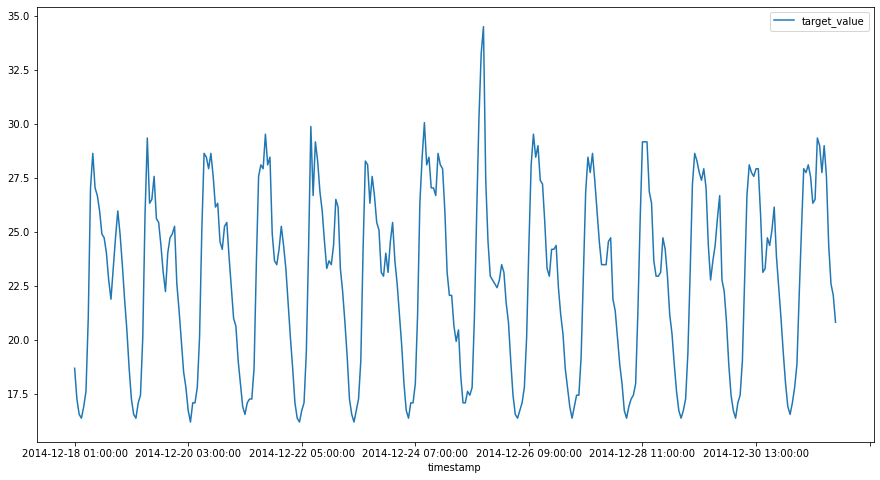

In [10]:
tdf[tdf['item_id'] == 'client_1'][-24*7*2:]\
    .plot(x='timestamp', y='target_value', figsize=(15, 8)); 

Next, we use an item metadata dataset that contains the information for both the non-cold start items (client 0 to 369) and cold start items (client 370 to 373). We call this meta information "type" in this specific case. Only one categorical feature is used in this demo, but in practice one normally has multiple categorical features.

Note that for cold start items where little to none demand history exists, the algorithm can only "transfer" information from the existing items to the new ones through the meta information. Therefore, having informative and high quality meta data is the key for a good cold-start forecast. 

In [11]:
# this metadata contains the cold start items' metadata as well.
localItemMetaDataFilePath = "data/itemMetaData.csv"
imdf = pd.read_csv(localItemMetaDataFilePath, dtype = object)

imdf.tail()

,item_id,type
369,client_369,D
370,client_370,A
371,client_371,B
372,client_372,C
373,client_373,D


And the following figure shows the histogram of the category "type."

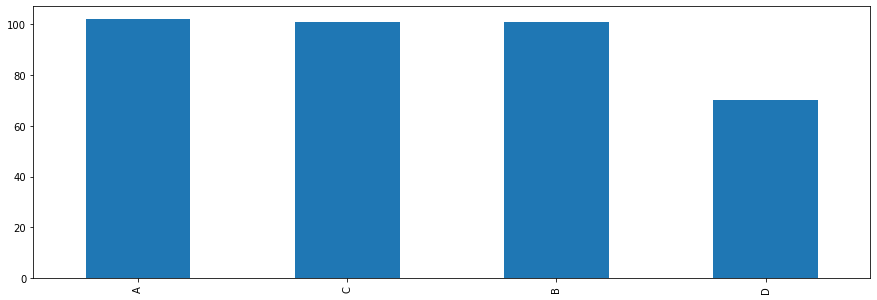

In [12]:
imdf['type'].value_counts().plot(kind='bar');

In [13]:
s3 = session.client('s3')

In [14]:
targetTimeseriesDatakey = "cold-start/test.csv"

s3.upload_file(Filename=localFilePath, Bucket = bucketName, Key = f"{targetTimeseriesDatakey}")

In [15]:
itemMetaDatakey = "cold-start/itemMetaData.csv"

s3.upload_file(Filename=localItemMetaDataFilePath, Bucket = bucketName, Key = f"{itemMetaDatakey}")

In [16]:
project = "coldstart_demo"

Below, we specify key input data and forecast parameters

In [17]:
freq = "H"
forecast_horizon = 48
timestamp_format = "yyyy-MM-dd HH:mm:ss"
delimiter = ','

## Step 2a. Creating a Dataset Group<a class="anchor" id="create">
First let's create a dataset group and then update it later to add our datasets.

In [18]:
dataset_group = f"{project}_grp"
dataset_arns = []
create_dataset_group_response = forecast.create_dataset_group(Domain="CUSTOM",
                                                          DatasetGroupName=dataset_group,
                                                          DatasetArns=dataset_arns)

In [19]:
dataset_group_arn = create_dataset_group_response['DatasetGroupArn']

## Step 2b. Creating a Target Dataset<a class="anchor" id="target">
In this example, we will define a target time series. This is a required dataset to use the service.

Below we specify the target time series name af_demo_ts_4.

In [20]:
ts_dataset_name = f"{project}_ts"
print(ts_dataset_name)

coldstart_demo_ts


Next, we specify the schema of our dataset below. Make sure the order of the attributes (columns) matches the raw 
data in the files. We follow the same three attribute format as the above example.

In [21]:
ts_schema_val = [{"AttributeName": "timestamp", "AttributeType": "timestamp"},
                {"AttributeName": "target_value", "AttributeType": "float"},
                {"AttributeName": "item_id", "AttributeType": "string"}]
ts_schema = {"Attributes": ts_schema_val}

In [22]:
response = forecast.create_dataset(Domain="CUSTOM",
                               DatasetType='TARGET_TIME_SERIES',
                               DatasetName=ts_dataset_name,
                               DataFrequency=freq,
                               Schema=ts_schema
                              )

ts_dataset_arn = response['DatasetArn']

## Step 2c. Creating ItemMetaData Dataset<a class="anchor" id="related">
In this example, we will define a Item Metadata Dataset.

In [23]:
item_metadata_dataset_name = f"{project}_meta"
print(item_metadata_dataset_name)

coldstart_demo_meta


Specify the schema of your dataset here. Make sure the order of columns matches the raw data files. We follow the same three column format as the above example.

In [24]:
meta_schema_val = [{"AttributeName": "item_id", "AttributeType": "string"},
              {"AttributeName": "category", "AttributeType": "string"}]
meta_schema = {"Attributes": meta_schema_val}

In [25]:
response = forecast.create_dataset(Domain="CUSTOM",
                               DatasetType='ITEM_METADATA',
                               DatasetName=item_metadata_dataset_name,
                               Schema=meta_schema
                              )

meta_dataset_arn = response['DatasetArn']

## Step 2d. Updating the dataset group with the datasets we created<a class="anchor" id="update">
You can have multiple datasets under the same dataset group. Update it with the datasets we created before.

In [26]:
dataset_arns = []
dataset_arns.append(ts_dataset_arn)
dataset_arns.append(meta_dataset_arn)
update_dataset_group_response = forecast.update_dataset_group(DatasetGroupArn=dataset_group_arn, DatasetArns=dataset_arns)

## Step 2e. Creating a Target Time Series Dataset Import Job<a class="anchor" id="targetImport">

In [27]:
ts_dataset_import_job_response = forecast.create_dataset_import_job(DatasetImportJobName=dataset_group+"_1",
                                                             DatasetArn=ts_dataset_arn,
                                                             DataSource= {
                                                                 "S3Config" : {
                                                                     "Path": f"s3://{bucketName}/{targetTimeseriesDatakey}",
                                                                     "RoleArn": role_arn
                                                                 } 
                                                             },
                                                             TimestampFormat=timestamp_format)

ts_dataset_import_job_arn=ts_dataset_import_job_response['DatasetImportJobArn']

## Step 2f. Creating a Item Meta Data Dataset Import Job<a class="anchor" id="relatedImport">

In [28]:
meta_dataset_import_job_response = forecast.create_dataset_import_job(DatasetImportJobName=dataset_group,
                                                             DatasetArn=meta_dataset_arn,
                                                             DataSource= {
                                                                 "S3Config" : {
                                                                     "Path": f"s3://{bucketName}/{itemMetaDatakey}",
                                                                     "RoleArn": role_arn
                                                                 } 
                                                             })

meta_dataset_import_job_arn=meta_dataset_import_job_response['DatasetImportJobArn']

## Step 2g. Wait on the two dataset import jobs to complete<a class="anchor" id="ImportWait">

In [29]:
status = util.wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=meta_dataset_import_job_arn))
assert status
status = util.wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))
assert status

CREATE_PENDING 
CREATE_IN_PROGRESS .........
ACTIVE 
CREATE_IN_PROGRESS ...........................
ACTIVE 


# Step 3. Create  Predictor with the datasets<a class="anchor" id="algo">

Read about the [Auto Predictor](https://github.com/aws-samples/amazon-forecast-samples/blob/main/library/content/AutoPredictor.md) to learn more.

In [30]:
PREDICTOR_NAME = project + "_predictor"

create_auto_predictor_response = \
    forecast.create_auto_predictor(PredictorName = PREDICTOR_NAME,
                                   ForecastHorizon = forecast_horizon,
                                   ForecastFrequency = freq,
                                   DataConfig = {
                                       'DatasetGroupArn': dataset_group_arn
                                    })

predictor_arn = create_auto_predictor_response['PredictorArn']
print(f"Waiting for Predictor to become ACTIVE. Depending on data size and predictor setting，it can take several hours to be ACTIVE.\n\nCurrent Status:")

status = util.wait(lambda: forecast.describe_auto_predictor(PredictorArn=predictor_arn))

describe_auto_predictor_response = forecast.describe_auto_predictor(PredictorArn=predictor_arn)
print(f"\n\nThe Predictor is now {describe_auto_predictor_response['Status']}.")
                                                   

Waiting for Predictor to become ACTIVE. Depending on data size and predictor setting，it can take several hours to be ACTIVE.

Current Status:
CREATE_PENDING ..
CREATE_IN_PROGRESS ...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
ACTIVE 


The Predictor is now ACTIVE.


# Step 4. Creating a Forecast<a class="anchor" id="forecast">

Next we re-train with the full dataset, and create the forecast.

In [31]:
FORECAST_NAME = project + "_forecast"

create_forecast_response = forecast.create_forecast(ForecastName=FORECAST_NAME,
                                                    PredictorArn=predictor_arn)

forecast_arn = create_forecast_response['ForecastArn']

print(f"Waiting for Forecast to become ACTIVE.\n\nCurrent Status:")

status = util.wait(lambda: forecast.describe_forecast(ForecastArn=forecast_arn))

Waiting for Forecast to become ACTIVE.

Current Status:
CREATE_PENDING 
CREATE_IN_PROGRESS ........................................................................
ACTIVE 


# Step 5. Querying the ColdStart Item Forecast<a class="anchor" id="query">
    
Now we plot the forecast.  First, we see there is <b>no historical data</b> for client_373 in the tdf dataframe.  Next, despite evidence of no history, a future prediction is made as shown in the plot.  client_373 is type D; therefore, the prediction is based on the distribution of values seen in other type D clients.

In [32]:
tdf[tdf['item_id'] == 'client_373']

,timestamp,target_value,item_id


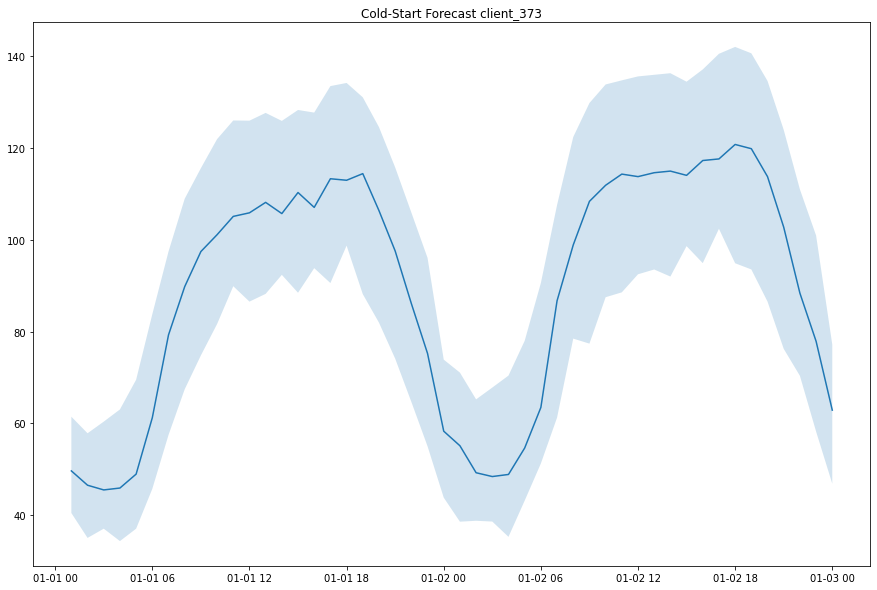

In [33]:
forecast_response = forecast_query.query_forecast(
    ForecastArn=forecast_arn,
    Filters={"item_id": "client_373"})

fcst = forecast_response['Forecast']['Predictions']
time_stamp = list(map(lambda x: pd.to_datetime(x['Timestamp']), fcst['p10']))
p10_fcst = list(map(lambda x: x['Value'], fcst['p10']))
p50_fcst = list(map(lambda x: x['Value'], fcst['p50']))
p90_fcst = list(map(lambda x: x['Value'], fcst['p90']))

plt.figure(figsize=(15, 10))
plt.plot(time_stamp, p50_fcst)
plt.fill_between(time_stamp, p10_fcst, p90_fcst, alpha=0.2)
plt.title("Cold-Start Forecast client_373");

# Step 6. Exporting your Forecasts<a class="anchor" id="export">
    
In step 5, the Forecast Query API is used to review single items for quality assurance and testing purposes.  For production scale, you should export the data in bulk to S3.  From there, you can use the data for many reasons including using in your BI platform or querying from a low latency database.

In [34]:
forecast_export_name = f'{project}_cold_start_forecast_export'
forecast_export_name_path = f"s3://{bucketName}/{forecast_export_name}"

In [35]:
create_forecast_export_response = forecast.create_forecast_export_job(ForecastExportJobName=forecast_export_name,
                                                        ForecastArn=forecast_arn,
                                                        Destination={
                                                            "S3Config" : {
                                                                "Path": forecast_export_name_path,
                                                                "RoleArn": role_arn
                                                            }
                                                        })
forecast_export_arn = create_forecast_export_response['ForecastExportJobArn']

status = util.wait(lambda: forecast.describe_forecast_export_job(ForecastExportJobArn = forecast_export_arn))
assert status

CREATE_PENDING .
CREATE_IN_PROGRESS ...........
ACTIVE 


# Step 7. Cleaning up your Resources<a class="anchor" id="cleanup">

Once you have completed the above steps, you can start to cleanup the resources we created. All delete jobs, except for `delete_dataset_group` are asynchronous, so we have added the helpful `wait_till_delete` function. 
Resource Limits documented <a href="https://docs.aws.amazon.com/forecast/latest/dg/limits.html">here</a>. 

In [ ]:
# Delete forecast export
util.wait_till_delete(lambda: forecast.delete_forecast_export_job(ForecastExportJobArn = forecast_export_arn))

In [ ]:
# Delete forecast
util.wait_till_delete(lambda: forecast.delete_forecast(ForecastArn = forecast_arn))

In [ ]:
# Delete predictor
util.wait_till_delete(lambda: forecast.delete_predictor(PredictorArn = predictor_arn))

In [ ]:
# Delete the target time series and related time series dataset import jobs
util.wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))
util.wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn=meta_dataset_import_job_arn))

In [ ]:
# Delete the target time series and related time series datasets
util.wait_till_delete(lambda: forecast.delete_dataset(DatasetArn=ts_dataset_arn))
util.wait_till_delete(lambda: forecast.delete_dataset(DatasetArn=meta_dataset_arn))

In [ ]:
# Delete dataset group
forecast.delete_dataset_group(DatasetGroupArn=dataset_group_arn)